# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента



**Оглавление** <a id="toc"></a>
1. [Подготовка данных](#15)
2. [Исследование задачи](#25)
3. [Борьба с дисбалансом](#35)
4. [Тестирование модели](#45)



# 1. Подготовка данных <a id =15></a>

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 

#Grapthics
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("precision", 2)
np.set_printoptions(precision=2)


In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
display(data.tail())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В датасэте 10 тысяч записей и 14 колонок. В столбце Tenure (количество недвижимости у клиента) имеются пропуски, чуть менее 10% от общей выборки. Есть небольшой потенциал по опитмизации типов.

In [5]:
#посмотрим квантили, средниие,СКО - поможет оценить разбросанность данных
# min and max - даст информацию для приведения типов
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,1.00e+04,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,1.57e+07,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,7.19e+04,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,1.56e+07,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,1.56e+07,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,1.57e+07,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.0
75%,7500.25,1.58e+07,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,1.58e+07,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


- Минимальные и максимальные значения на первый взгляд адекватные. Явных выбросов на первый взгляд не видно. 
- По булевым столбцам ``HasCrCard,IsActiveMember,Exited`` можно предварительно оценить баланс классов. У 70% есть карты, а активных пользователей примерно поровну.
- По отношение средних и медиан моженм предварительно прикиноуть нормальность распределения данных 

In [6]:
#посмотрим как распределены классы в целевом признаке
data['Exited'].value_counts(normalize=True)

0    0.8
1    0.2
Name: Exited, dtype: float64

Рассмотрим целевой признак, 20% клиентов уходят из банка. Довольно много. Но в данном случае не будем искать причину, а будем прогнозировать отток уже существующих клиентов.

In [7]:
data_nan = data[data['Tenure'].isnull()]
data_nan.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.00,9.09e+02,909.00,909.00,0.0,909.00,909.00,909.00,909.00,909.00,909.0
mean,4866.39,1.57e+07,648.45,38.65,NaN,76117.34,1.53,0.71,0.51,99180.39,0.2
std,2909.60,7.51e+04,99.08,9.79,NaN,63105.69,0.59,0.45,0.50,56378.06,0.4
min,31.00,1.56e+07,359.00,18.00,NaN,0.00,1.00,0.00,0.00,106.67,0.0
25%,2311.00,1.56e+07,580.00,32.00,NaN,0.00,1.00,0.00,0.00,49872.33,0.0
50%,4887.00,1.57e+07,647.00,37.00,NaN,96674.55,1.00,1.00,1.00,99444.02,0.0
75%,7306.00,1.58e+07,718.00,43.00,NaN,128554.98,2.00,1.00,1.00,145759.70,0.0
max,10000.00,1.58e+07,850.00,92.00,NaN,206663.75,4.00,1.00,1.00,199390.45,1.0


В пропущенных данных баланс классов не нарушен. Попробуем заполнить по категориям

In [8]:
# проанализируем показатель количества недвижимости в различных разрезах. Это поможет нам понять как заполнить пропуски.
list_columns = ['Geography','Gender','NumOfProducts', 'HasCrCard','IsActiveMember','Exited']
for column in list_columns:
    display(data.groupby(column).agg({'Tenure':['count','median','mean']}))


Tenure             
           count median  mean
Geography                    
France      4550    5.0  5.00
Germany     2293    5.0  4.98
Spain       2248    5.0  5.00

Tenure             
        count median  mean
Gender                    
Female   4117    5.0  4.96
Male     4974    5.0  5.03

Tenure             
               count median  mean
NumOfProducts                    
1               4617    5.0  4.96
2               4184    5.0  5.03
3                234    5.0  5.00
4                 56    5.0  5.23

Tenure             
           count median  mean
HasCrCard                    
0           2682    5.0  4.88
1           6409    5.0  5.05

Tenure             
                count median  mean
IsActiveMember                    
0                4404    5.0  5.09
1                4687    5.0  4.91

Tenure             
        count median  mean
Exited                    
0        7237    5.0  5.02
1        1854    5.0  4.90

In [9]:
# видим что во всех разрезах медианные значения равны 5 объектам СКО 3. Заполним пропуски.
print(data['Tenure'].isnull().sum())
data['Tenure'] = data['Tenure'].fillna(random.randint(1,9))
#data.dropna(subset=['Tenure'],inplace=True)
print(data['Tenure'].isnull().sum())

909
0


In [10]:
# удалим колонки 'RowNumber','Surname','CustomerId' это неинформативные признаки
data.drop(['RowNumber','Surname','CustomerId'],axis=1,inplace =True)

In [11]:
#исследуем данные на мультиколлинеарность. 
corr_table = data.corr().unstack().sort_values(kind="quicksort",ascending=False)
#топ 10 по положиетельным корреляциями
print( corr_table[9:19])
#топ 15 по отридцательным корреляциям
display( corr_table[-10:].sort_values(kind="quicksort",ascending=True))

Exited          Age               0.29
Age             Exited            0.29
Balance         Exited            0.12
Exited          Balance           0.12
Age             IsActiveMember    0.09
IsActiveMember  Age               0.09
Age             Balance           0.03
Balance         Age               0.03
Tenure          HasCrCard         0.03
HasCrCard       Tenure            0.03
dtype: float64


Balance         NumOfProducts    -0.30
NumOfProducts   Balance          -0.30
IsActiveMember  Exited           -0.16
Exited          IsActiveMember   -0.16
                NumOfProducts    -0.05
NumOfProducts   Exited           -0.05
Age             NumOfProducts    -0.03
NumOfProducts   Age              -0.03
Tenure          IsActiveMember   -0.03
IsActiveMember  Tenure           -0.03
dtype: float64

Признаков с высокой степенью мультиколинеарности не выявлено. Гипотеза о мультиколинеарных признаках отвергнута. На основании этих даных так же можно сделать несколько гипотиз, в какую сторону нужно искать отток клиентов. Но, в данном проекте перед нами таких задач не поставлено.

In [12]:
#Подготовим стобец Gender для преобразования в булевый 
data['Gender'] = data['Gender'].map({'Female':0,'Male':1})

In [13]:
# осуществим преобразования типов, чтобы корректно применялись методы библиотек
# и чтобы уменьшить ресурсоемкость наших вычислений
data['CreditScore'] = data['CreditScore'].astype('uint64')
data['Geography'] = data['Geography'].astype('category')
data['Gender'] = data['Gender'].astype('bool')
data['Age'] = data['Age'].astype('uint16')
data['Tenure'] = data['Tenure'].astype('float16')
data['NumOfProducts'] = data['NumOfProducts'].astype('uint16')
data['HasCrCard'] = data['HasCrCard'].astype('bool')
data['IsActiveMember'] = data['IsActiveMember'].astype('bool')
data['Exited'] = data['Exited'].astype('bool')

Посредством приведения типов мы добились уменьшения в памяти обьема наших данных более чем в 2 раза. На больших выборках скорость обработки данных с приведением типов и без будет существенно отличатся.

In [14]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,False,42,2.0,0.00,1,True,True,101348.88,True
1,608,Spain,False,41,1.0,83807.86,1,False,True,112542.58,False
2,502,France,False,42,8.0,159660.80,3,True,False,113931.57,True
3,699,France,False,39,1.0,0.00,2,False,False,93826.63,False
4,850,Spain,False,43,2.0,125510.82,1,True,True,79084.10,False


In [15]:
#у нас остался один категориальный признак, исправим это
data['Geography'].dtypes

CategoricalDtype(categories=['France', 'Germany', 'Spain'], ordered=False)

**Делим выборки на тренировочную, тестовую и валидационную**

In [16]:
# разобьем выборку на тестовую и валидационную
# учтем при разбиении соотношение целевых классов. Перемешаем данные, т.к. мы заполняли их пропусками
feature = data.drop('Exited',axis=1)
target = data['Exited']
feature_train,feature_test_valid,target_train, target_test_valid = train_test_split(feature,target,\
test_size=0.4,random_state=890,shuffle=True,stratify =target )
feature_train  = feature_train.reset_index(drop=True)
target_train  = target_train.reset_index(drop=True)
#проверим карректно ли мы разделили выборки
display(target_train.value_counts(normalize=True),len(target_train))
target_test_valid.value_counts(normalize=True)

False    0.8
True     0.2
Name: Exited, dtype: float64

6000

False    0.8
True     0.2
Name: Exited, dtype: float64

In [17]:
#раздели данные на тестовую и валидационную
feature_valid,feature_test ,target_valid , target_test  = train_test_split(feature_test_valid ,target_test_valid,\
test_size=0.5,random_state=890,shuffle=True,stratify =target_test_valid )
#проверим карректно ли мы разделили выборки
feature_valid  = feature_valid.reset_index(drop=True)
feature_test  = feature_test.reset_index(drop=True)
target_valid  = target_valid.reset_index(drop=True)
target_valid  = target_valid.reset_index(drop=True)
#cмотрим на индексы
display(feature_valid.tail())
display(feature_test.tail())
#смотрим на соотношение классов и размер выборки
display(target_valid .value_counts(normalize=True), len(target_valid ))
display(target_test .value_counts(normalize=True), len(target_valid ))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1995,567,Spain,True,35,8.0,153137.74,1,True,False,88659.07
1996,658,France,True,36,8.0,174060.46,1,True,True,94925.62
1997,443,France,False,54,3.0,138547.97,1,True,True,70196.23
1998,643,France,True,37,6.0,0.00,2,False,False,142454.77
1999,585,Spain,False,33,8.0,0.00,2,True,False,114182.07


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1995,790,France,False,31,9.0,0.00,2,True,False,84126.75
1996,691,Germany,False,38,5.0,114753.76,1,True,False,107665.02
1997,639,France,False,42,4.0,0.00,2,False,False,167682.37
1998,598,Spain,True,44,8.0,0.00,2,True,False,148487.90
1999,543,Spain,False,46,5.0,140355.60,1,True,True,85086.78


False    0.8
True     0.2
Name: Exited, dtype: float64

2000

False    0.8
True     0.2
Name: Exited, dtype: float64

2000

**Перекодируем признаки Ordinal encoding**

Для Деревьев решений и бустинга нужно применять технику Ordinal Encoding. В отличии от One Hot encoding эта техника не создает много столбцов с бинарным присвоением признака, а производит ранжирование в одном столбце.

In [18]:
#подготоим данные для OE
categories = ['Geography','Gender','HasCrCard','IsActiveMember']
encoder_OE = OrdinalEncoder()
def oe_encode_fit_transform(_data):
    encoded_data = pd.DataFrame(encoder_OE.fit_transform(_data),columns=_data.columns,index=_data.index)
    return encoded_data
def oe_encode_fit(_data):
    encoded_data = pd.DataFrame(encoder_OE.fit_transform(_data),columns=_data.columns,index=_data.index)
    return encoded_data

feature_train_oe = feature_train.copy()
feature_valid_oe = feature_valid.copy()
feature_test_oe = feature_test.copy()
#feature_train_oe.drop(['Geography','Gender','HasCrCard','IsActiveMember'],axis=1,inplace=True)
feature_train_oe[categories] = oe_encode_fit_transform(feature_train[categories])
feature_valid_oe[categories] = oe_encode_fit(feature_valid[categories])
feature_test_oe[categories] = oe_encode_fit(feature_test[categories])

display(feature_train_oe.tail(2))
display(feature_valid_oe.tail(2))
display(feature_test_oe.tail(2))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5998,717,0.0,1.0,35,4.0,0.0,1,1.0,1.0,167573.06
5999,565,0.0,0.0,40,2.0,0.0,2,1.0,1.0,129956.13


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1998,643,0.0,1.0,37,6.0,0.0,2,0.0,0.0,142454.77
1999,585,2.0,0.0,33,8.0,0.0,2,1.0,0.0,114182.07


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1998,598,2.0,1.0,44,8.0,0.0,2,1.0,0.0,148487.90
1999,543,2.0,0.0,46,5.0,140355.6,1,1.0,1.0,85086.78


**Смасштабируем признаки Ordinal encoding**

In [19]:
feature_train_oe_sc = feature_train_oe.copy().reset_index(drop=True)
scaler_oe = StandardScaler()
scaler_oe.fit(feature_train_oe_sc)
#масштабируем тестовую, валидационную и тренировочную выборки
def local_scaler_oe (feature):
    feature_oe_sc = pd.DataFrame(scaler_oe.transform(feature),columns=feature.columns)
    display(feature_oe_sc.tail(2))
    return feature_oe_sc
feature_train_oe_sc =local_scaler_oe(feature_train_oe)
feature_valid_oe_sc =local_scaler_oe(feature_valid_oe)
feature_test_oe_sc  =local_scaler_oe(feature_test_oe)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5998,0.71,-0.9,0.92,-0.36,-0.45,-1.23,-0.90,0.65,0.96,1.20
5999,-0.87,-0.9,-1.08,0.11,-1.14,-1.23,0.82,0.65,0.96,0.54


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1998,-0.06,-0.90,0.92,-0.17,0.24,-1.23,0.82,-1.54,-1.04,0.76
1999,-0.66,1.51,-1.08,-0.55,0.94,-1.23,0.82,0.65,-1.04,0.26


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1998,-0.53,1.51,0.92,0.49,0.94,-1.23,0.82,0.65,-1.04,0.86
1999,-1.10,1.51,-1.08,0.68,-0.10,1.02,-0.90,0.65,0.96,-0.25


**Перекодируем признаки OHE**

In [20]:
# Представим категориальный признак в виде бинарных, применив OHE
feature_train_ohe = pd.get_dummies(feature_train,drop_first=True)
feature_valid_ohe = pd.get_dummies(feature_valid,drop_first=True)
feature_test_ohe = pd.get_dummies(feature_test,drop_first=True)
display(feature_train_ohe)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,673,False,40,5.0,137494.28,1,True,False,81753.92,0,0
1,457,True,42,4.0,126772.57,1,False,True,126106.40,1,0
2,415,True,46,9.0,134950.19,3,False,False,178587.36,0,0
3,594,True,23,5.0,156267.59,1,True,False,160968.44,0,0
4,776,False,38,2.0,169824.46,1,True,False,169291.70,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5995,553,True,31,6.0,0.00,2,False,False,124596.63,0,0
5996,634,False,36,1.0,69518.95,1,True,False,116238.39,0,0
5997,850,False,27,7.0,43658.33,2,True,True,3025.49,0,0
5998,717,True,35,4.0,0.00,1,True,True,167573.06,0,0


Преобразовать категориальные признаки в численные помогла техника прямого кодирования, или отображения (**One-Hot Encoding, OHE**). Вместо одного признака мы получили 3 ['France', 'Germany', 'Spain'], и ``один из них удалили(dummy varible)``, чтобы не попасть в Дамми ловушку. Т.к. Восстановить удаленный столбец можно по оставшимся двум. 

**Масштабирование OHE**

In [21]:
# Если не сделать reset_index(), то масштабирование пройдет некорректно
feature_train_ohe_sc = feature_train_ohe.copy().reset_index(drop=True)
scaler_ohe = StandardScaler()
scaler_ohe.fit(feature_train_ohe_sc)
#масштабируем тестовую, валидационную и тренировочную выборки
def local_scaler_ohe (feature):
    feature_ohe_sc = pd.DataFrame(scaler_ohe.transform(feature),columns=feature.columns)
    display(feature_ohe_sc.tail(2))
    return feature_ohe_sc
feature_train_ohe_sc =local_scaler_ohe(feature_train_ohe)
feature_valid_ohe_sc =local_scaler_ohe(feature_valid_ohe)
feature_test_ohe_sc  =local_scaler_ohe(feature_test_ohe)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
5998,0.71,0.92,-0.36,-0.45,-1.23,-0.90,0.65,0.96,1.20,-0.58,-0.57
5999,-0.87,-1.08,0.11,-1.14,-1.23,0.82,0.65,0.96,0.54,-0.58,-0.57


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
1998,-0.06,0.92,-0.17,0.24,-1.23,0.82,-1.54,-1.04,0.76,-0.58,-0.57
1999,-0.66,-1.08,-0.55,0.94,-1.23,0.82,0.65,-1.04,0.26,-0.58,1.74


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
1998,-0.53,0.92,0.49,0.94,-1.23,0.82,0.65,-1.04,0.86,-0.58,1.74
1999,-1.10,-1.08,0.68,-0.10,1.02,-0.90,0.65,0.96,-0.25,-0.58,1.74


**Подготовим  данные для кросс валидации**

In [22]:
_merge = pd.merge(feature_train_oe_sc,feature_valid_oe_sc,how='outer')
feature_cross_oe_sc = pd.merge(_merge,feature_test_oe_sc,how='outer')
display(feature_cross_oe_sc.shape)

(10000, 10)

In [23]:
_merge = pd.merge(feature_train_ohe_sc,feature_valid_ohe_sc,how='outer')
feature_cross_ohe_sc = pd.merge(_merge,feature_test_ohe_sc,how='outer')
display(feature_cross_ohe_sc.shape)

(10000, 11)

Что мы сделали:
- просмотрели данные на предмет выбросов и адекватных значений.
- удалили неинформативные признаки ``'RowNumber','Surname',"CustomerId"``. Они бы мешали модели обучаться.
- проанализировали пропуски в столбце ``'Tenure'`` и решили его заполнить медианным значением 5.0
- исследовали данные на предмет мультиколлинеарности. Признаков с высокой корреляцией не выявлено.
- Подготовили данные столбца ``'Gender'`` для преобразования в булевый тип
- преобразовали типы данных. Это поможет нам применять соответствующие методы библиотек и оптимизирует производительность вычислений
- Преобразовали категориальный признак ``'Geography'`` в числовой. Используя технику прямого кодирования One-Hot Encoding, OHE.
-  поделили данные на 3 выборки тренировочная(70%) валидационная(18%) и тестовая (12%)
- осуществили масштабирование признаков для тренировочной, тестовой и валидационных выборок по методикам One Hot Encoding и Ordinal Encoding
- подготовили данные для кросс валидации

# 2. Исследование задачи <a id =25></a>

**Изучим модель без учета баланса класса**

**DecisionTreeClassifier**

In [24]:
#расчет универсальных метрик для алгоритма
def metrics_calculate(feature_train,target_train,feature_valid,target_valid,predicted_valid,probabilities_valid = None):
    model_metrics = []
    tn, fp, fn, tp = confusion_matrix(target_valid,predicted_valid).ravel()
    precision = precision_score(target_valid,predicted_valid) 
    recall = recall_score(target_valid,predicted_valid)
    _f1_score = f1_score(target_valid,predicted_valid)
    accuracy = accuracy_score(target_valid,predicted_valid)
    #print(np.mean(probabilities_valid[:, 1]))
    model_metrics.append([tn, fp, fn, tp,precision,recall,_f1_score,accuracy])
    #model_metrics = pd.DataFrame(model_metrics,columns=['tn', 'fp', 'fn', 'tp','precision','recall','_f1_score'])
    #display(model_metrics)
    return np.hstack((model_metrics))

#перечень метрик для инициализации массива и формирования заголовка к DF
def list_metrics():
    metrics = ['tn', 'fp', 'fn', 'tp','precision','recall','_f1_score','accuracy']
    return metrics

#создадим график с pr кривой
def PR_curve(target_valid, probabilities_valid):
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
    plt.figure(figsize=(4, 4))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

# график ROC AUC кривой
def ROC_curve(target_valid,predicted_value_proba):
    fpr, tpr, thresholds = roc_curve(target_valid, predicted_value_proba[:,1])
    plt.figure()
    plt.plot(fpr,tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    #посчитаем  Area Under Curve ROC, площадь под кривой 
    auc_roc = roc_auc_score(target_valid, predicted_value_proba[:,1])
    print('Площадь под кривой AUC-ROC равна',auc_roc)
    
#функция выбора уставки
def threshold_selection(predicted_value,predict_proba,target_valid):
    #убедимся что мы все делаем правильно и при пороге 0.5 получаем тот же результат
    display(pd.Series((predict_proba[:,1]>0.5)).value_counts())
    display(pd.Series(predicted_value).value_counts())
    display(pd.Series(target_valid).value_counts())
    #возьмем массив с вероятностями и подберем порог
    probabilities_one_valid = predict_proba[:,1]
    score = []
    
    for threshold in np.arange(0.2, 0.7, 0.02):
        predicted_valid = pd.Series(probabilities_one_valid > threshold)
        _f1_score = f1_score(target_valid,predicted_valid)
        score.append([_f1_score,threshold])
    #преобразуем табличку с порогами, сортируем и выводим  
    score = pd.DataFrame(score,columns=['f1_score','threshold'])     
    display(score.sort_values(by =score.columns[0], ascending=False).head(20).T)
    ax =score.plot(x='threshold',y='f1_score',kind='line');
    plt.show()

In [25]:
def DecisionTreeClassifier_model(feature_train,target_train,feature_valid,target_valid):
    #созадим заголовок для таблицы метрик и кгиперпараметров
    metrics = np.hstack((list_metrics()+['depth','class_weight']))
    for weight1 in ['None','balanced']:
        for depth in range(2,20):
            if (weight1 == 'None'):
                weight1 = None
            model_DT = DecisionTreeClassifier(random_state=890,criterion='entropy',max_depth = depth,class_weight=weight1)
            model_DT.fit(feature_train,target_train)
            predict_DT = model_DT.predict(feature_valid)
            current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_DT,None)
            #добавим гиперпараметры в таблицу с метриками
            current_metrics = np.hstack((np.hstack((current_metrics,[depth,str(weight1)]))))
            metrics = np.vstack((metrics,current_metrics))
    #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
#вызовем построение модели  
metrics_DT =DecisionTreeClassifier_model(feature_train_oe_sc,target_train,feature_valid_oe_sc,target_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,depth,class_weight
7,1512.0,80.0,214.0,194.0,0.708029197080292,0.47549019607843135,0.5689149560117301,0.853,8,None
22,1322.0,270.0,141.0,267.0,0.4972067039106145,0.6544117647058824,0.5650793650793651,0.7945,5,balanced
9,1498.0,94.0,213.0,195.0,0.6747404844290658,0.47794117647058826,0.5595408895265424,0.8465,10,None
11,1472.0,120.0,203.0,205.0,0.6307692307692307,0.5024509803921569,0.5593451568894953,0.8385,12,None
26,1232.0,360.0,115.0,293.0,0.44869831546707506,0.7181372549019608,0.5523091423185674,0.7625,9,balanced
24,1223.0,369.0,112.0,296.0,0.44511278195488724,0.7254901960784313,0.5517241379310345,0.7595,7,balanced
10,1476.0,116.0,209.0,199.0,0.6317460317460317,0.4877450980392157,0.5504840940525587,0.8375,11,None
4,1536.0,56.0,232.0,176.0,0.7586206896551724,0.43137254901960786,0.55,0.856,5,None
25,1211.0,381.0,109.0,299.0,0.43970588235294117,0.7328431372549019,0.5496323529411765,0.755,8,balanced
23,1198.0,394.0,105.0,303.0,0.4347202295552367,0.7426470588235294,0.5484162895927602,0.7505,6,balanced


Эксперименты с балансировкой класса посредством гиперпараметра ``class_weight='balanced'`` не принесли значительного поднятия метрики F1. Хотя если смотреть на лидерборд, то дерево показывает лучшие результаты с меньшей глубиной, чем без ``'balanced'``.  Напомним, что алгоритм считает, во сколько раз класс «0» встречается чаще класса «1». Попробуем upsampling и undersampling, возможно они повысят нам _f1_score. 

**RandomForestClassifier**

In [26]:
def RandomForestClassifier_model(feature_train,target_train,feature_valid,target_valid):
    #созадим заголовок для таблицы метрик и гиперпараметров
    metrics = np.hstack((list_metrics()+['n_estimators']))
    for depth in range(5,15,3):
        for n_estimators in range(1,8,2):
            rfc = RandomForestClassifier(random_state=890, n_estimators= n_estimators);
            rfc.fit(feature_train,target_train);
            predict_valid = rfc.predict(feature_valid)
            current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_valid,None)
            #добавим гиперпараметры в таблицу с метриками
            current_metrics = np.hstack((np.hstack((current_metrics,[n_estimators]))))
            metrics = np.vstack((metrics,current_metrics))
        #print(metrics)
    #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
    
metrics_RF = RandomForestClassifier_model(feature_train_oe_sc,target_train,feature_valid_oe_sc,target_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,n_estimators
4,1505.0,87.0,208.0,200.0,0.6968641114982579,0.49019607843137253,0.5755395683453237,0.8525,7.0
8,1505.0,87.0,208.0,200.0,0.6968641114982579,0.49019607843137253,0.5755395683453237,0.8525,7.0
12,1505.0,87.0,208.0,200.0,0.6968641114982579,0.49019607843137253,0.5755395683453237,0.8525,7.0
16,1505.0,87.0,208.0,200.0,0.6968641114982579,0.49019607843137253,0.5755395683453237,0.8525,7.0
3,1476.0,116.0,203.0,205.0,0.6386292834890965,0.5024509803921569,0.5624142661179699,0.8405,5.0
7,1476.0,116.0,203.0,205.0,0.6386292834890965,0.5024509803921569,0.5624142661179699,0.8405,5.0
11,1476.0,116.0,203.0,205.0,0.6386292834890965,0.5024509803921569,0.5624142661179699,0.8405,5.0
15,1476.0,116.0,203.0,205.0,0.6386292834890965,0.5024509803921569,0.5624142661179699,0.8405,5.0
2,1463.0,129.0,206.0,202.0,0.6102719033232629,0.4950980392156863,0.5466847090663058,0.8325,3.0
6,1463.0,129.0,206.0,202.0,0.6102719033232629,0.4950980392156863,0.5466847090663058,0.8325,3.0


Попробуем ``альтернативный способ подбора гиперпараметров`` в связке **RandomizedSearchCV** и **GridSearchCV**

 n_estimators — число «деревьев» в «случайном лесу».
<br> max_features — число признаков для выбора расщепления.
<br> max_depth — максимальная глубина деревьев.
<br> min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
<br> min_samples_leaf — минимальное число объектов в листьях.
<br> bootstrap — использование для построения деревьев подвыборки с возвращением.

При значениях параметров n_iter = 10 и cv = 3, мы создали 30 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров.

In [27]:
#RandomizedSearchCV
rfc_2 = RandomForestClassifier(n_jobs=-1,
                            random_state=890)

# диапазоны для перебора будем брать 
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 3)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 1)]
min_samples_leaf = range(3, 15,1)
bootstrap = [True, False]
criterion = ["gini", "entropy"]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                "criterion": criterion
             }
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, # сейчас стоит 5 для теста, при финальных рассчетах поставим 20
                        cv = 10, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=890)
rs.fit(feature_train_oe_sc, target_train)
print(rs.best_params_)
#rs.cv_results_
#{'n_estimators': 273,
#'min_samples_split': 21,
#'min_samples_leaf': 5,
#'max_features': 'sqrt',
#'max_depth': 40,
#'bootstrap': False}

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 532, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}


In [28]:
#посмотрим лучшие результаты RandomizedSearchCV
rs_df = pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
display(rs_df.T)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
param_n_estimators,532,979,187,654,959,86,695,776,654,228,...,329,614,329,837,512,614,959,25,25,5
param_min_samples_split,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_samples_leaf,5,3,9,3,4,13,12,6,14,7,...,4,4,11,5,9,14,8,8,9,3
param_max_features,log2,log2,log2,log2,sqrt,log2,log2,sqrt,log2,sqrt,...,log2,log2,log2,sqrt,sqrt,sqrt,log2,log2,log2,sqrt
param_max_depth,20,11,11,11,20,11,20,11,11,11,...,3,3,3,3,3,3,3,3,3,3
param_criterion,entropy,entropy,entropy,entropy,entropy,entropy,entropy,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,gini,gini,entropy
param_bootstrap,True,True,False,True,True,False,False,True,False,True,...,True,True,True,True,True,True,True,False,True,True
split3_test_score,0.86,0.86,0.86,0.86,0.85,0.86,0.86,0.85,0.85,0.86,...,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.82,0.82,0.81
split4_test_score,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85,...,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.81,0.82
split5_test_score,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,...,0.82,0.83,0.82,0.83,0.83,0.83,0.83,0.83,0.82,0.81


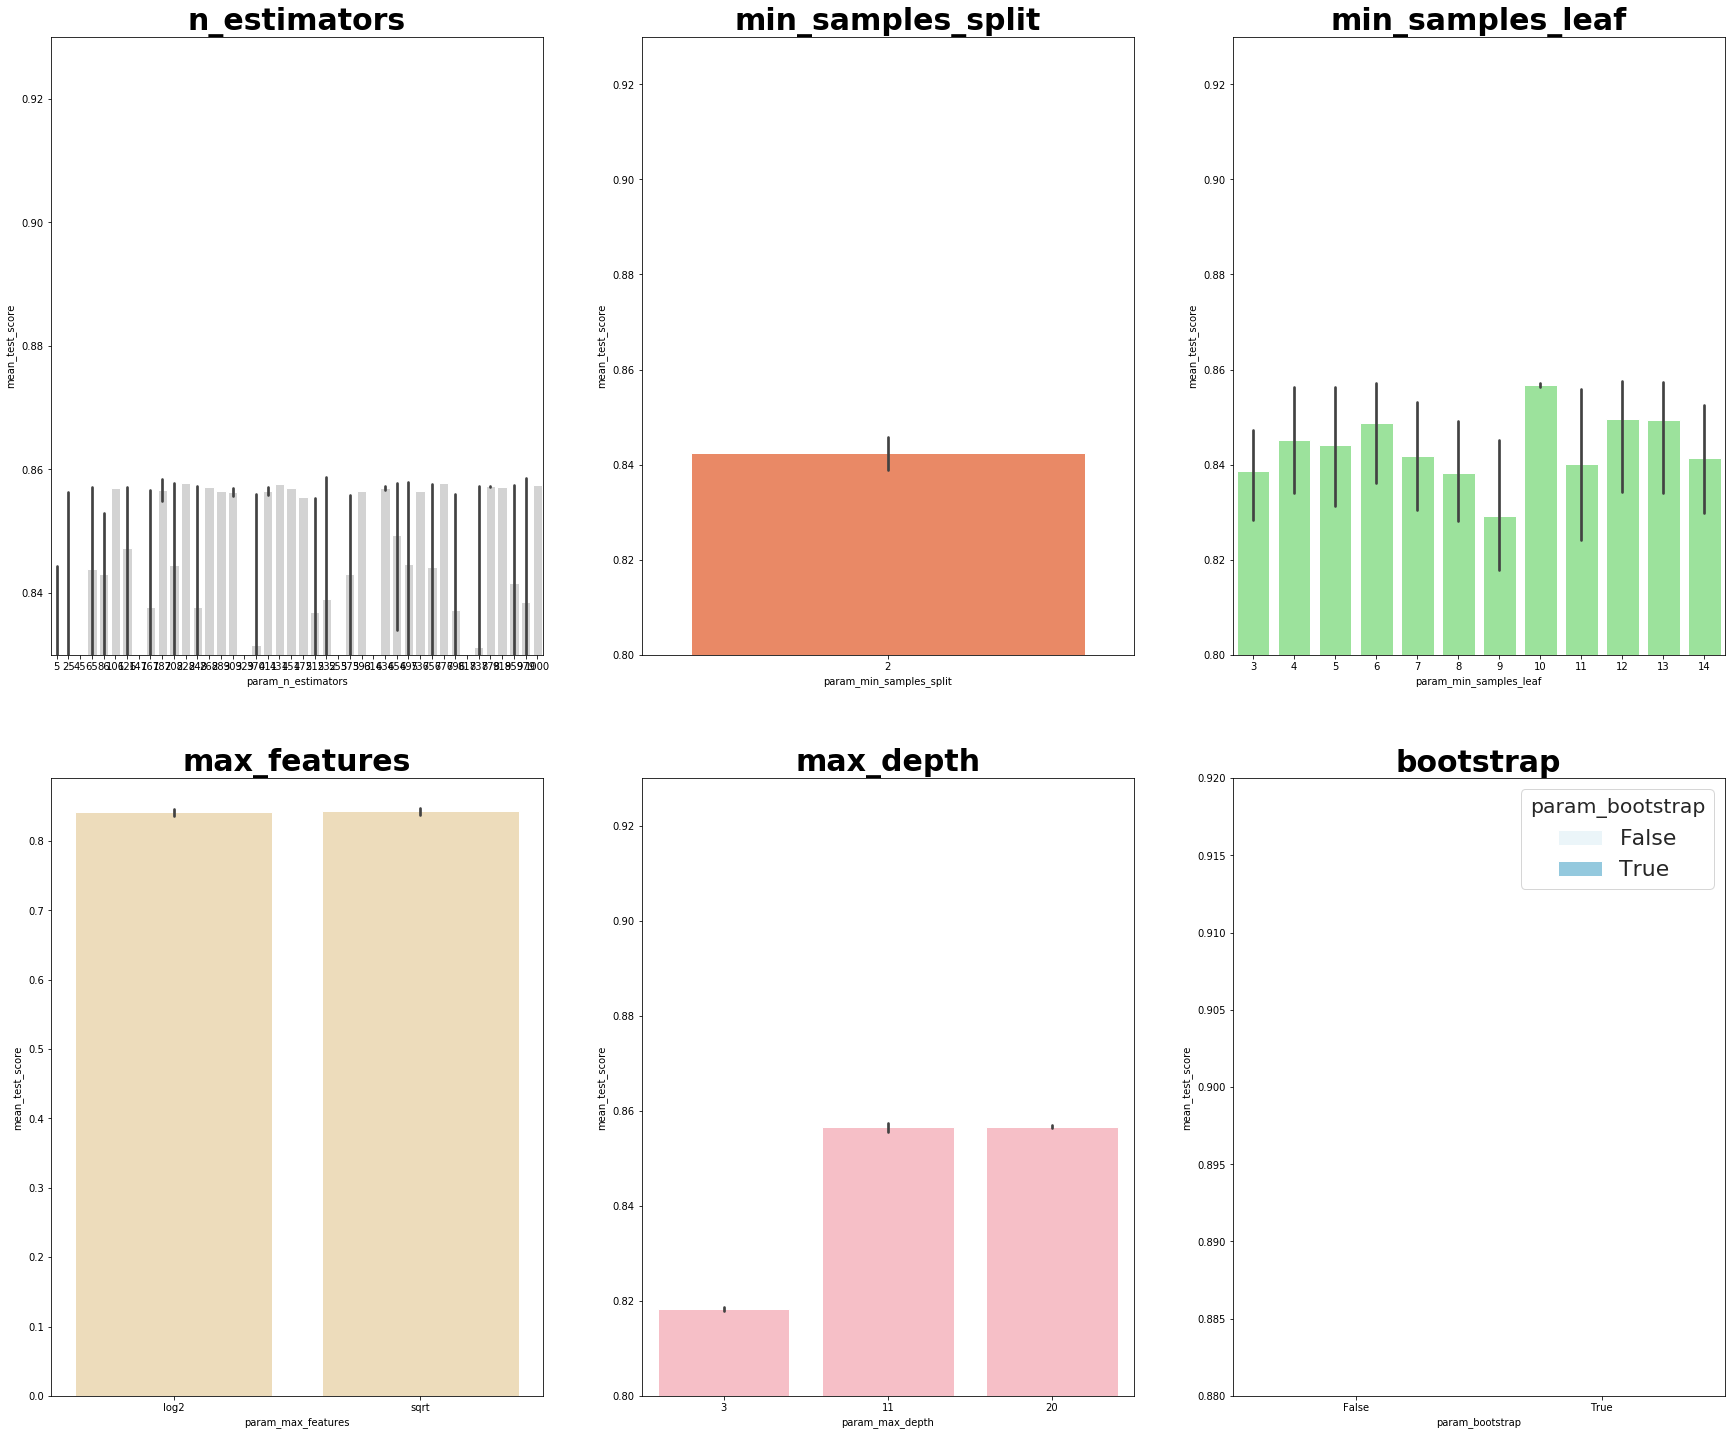

In [29]:
# проанализируем значения гиперпараметров, чтобы потом экспертно откорректировать гиперпараметры модели
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.80,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue',hue='param_bootstrap')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Если проанализировать вышеприведённые графики, то можно заметить некоторые интересные вещи, говорящие о том, как, в среднем, каждое значение гиперпараметра влияет на модель.

<br>n_estimators: значения 100, 400, 900, видимо, показывают наилучшие средние результаты.Но оставим 100, т.к. переобучать модель нам никчему.
<br>min_samples_split: маленькие значения, , как кажется, показывают наилучшие результаты. Хорошо выглядит и значение 23. Можно исследовать несколько значений этого гиперпараметра, превышающих 2, а также — несколько значений около 23.
<br>min_samples_leaf: возникает такое ощущение, что маленькие значения этого гиперпараметра дают более высокие результаты. А это значит, что мы можем испытать значения между 9 и 11
<br>max_features: вариант sqrt даёт самый высокий средний результат.
<br>max_depth: тут чёткой зависимости между значением гиперпараметра и результатом работы модели не видно, но есть ощущение, что значения 5,10,15,20 выглядят неплохо.
<br>bootstrap: значение False показывает наилучший средний результат.

Подбираем перебором признаки с помощью **RandomizedSearchCV**

In [30]:
rfc_3 = RandomForestClassifier(n_jobs=-1,
                            random_state=890)
n_estimators = [100,600,400]
max_features = ['log2','sqrt']
max_depth = [2,3,4,16,30]
min_samples_split = [2]
min_samples_leaf = [4,7,10,11]
bootstrap = [False,True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc_3, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(feature_train_oe_sc, target_train)
print(gs.best_estimator_)
print('rewrewrfweerfwf')
print(gs.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=7,
                       n_jobs=-1, random_state=890)
rewrewrfweerfwf
{'bootstrap': True, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100}


Результат после подбора параметрами RandomizedSearchCV и GridSearchCV для f1_score 0.5526770293609672 не сильно превзошел обычное дерево (0.54). Возможно нужно дать больше диапазон для RandomizedSearchCV. 

Результат после подбора параметрами RandomizedSearchCV и GridSearchCV для f1_score 0.555735056542811


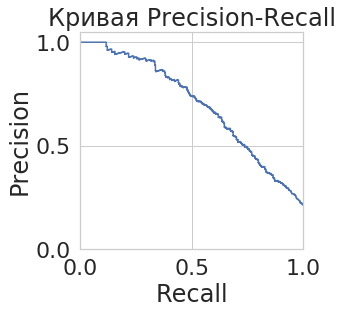

False    1789
True      211
dtype: int64

False    1789
True      211
dtype: int64

False    1592
True      408
Name: Exited, dtype: int64

,6,7,8,4,5,9,3,10,2,12,11,1,0,14,13,15,16,17,18,19
f1_score,0.64,0.63,0.62,0.62,0.62,0.62,0.61,0.61,0.60,0.59,0.59,0.59,0.58,0.57,0.57,0.56,0.55,0.53,0.53,0.52
threshold,0.32,0.34,0.36,0.28,0.30,0.38,0.26,0.40,0.24,0.44,0.42,0.22,0.20,0.48,0.46,0.50,0.52,0.54,0.56,0.58


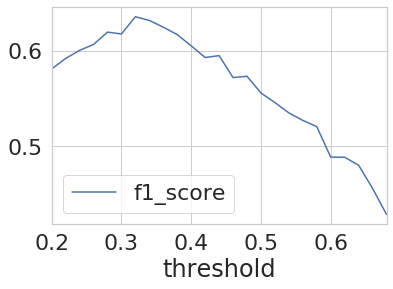

In [31]:
#best_params ={'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 23, 'n_estimators': 300}
#возьмем лучшие параметры после GridSearch
best_params = gs.best_params_
#best_params = rs.best_params_
def RandomForestClassifier_model(params,feature_train, target_train,feature_valid,target_valid):
    rfc_4 = RandomForestClassifier(**params)
    rfc_4.fit(feature_train, target_train)
    predicted_value = rfc_4.predict(feature_valid.values)
    predicted_value_proba = rfc_4.predict_proba(feature_valid.values)
    _f1_score = f1_score(target_valid,predicted_value)
    print('Результат после подбора параметрами RandomizedSearchCV и GridSearchCV для f1_score', _f1_score)
    #построим pr кривую PR(precision and recall)
    PR_curve(target_valid,predicted_value_proba)
    return predicted_value,predicted_value_proba
predicted_value_RF,predicted_value_proba_RF = RandomForestClassifier_model(best_params,feature_train_oe_sc,target_train,feature_valid_oe_sc,target_valid)
threshold_selection(predicted_value_RF,predicted_value_proba_RF,target_valid)


Видим что лучшее значение порога будет в районе 0.3-4

Поэксперементировав немного с пророгом четко видно что при значении порога 0.3 мы получили значение метрики **F1** ``0.6, против 0.55 при пороге 0.5``. Будем считать это маленьким успехом. 

**LogisticRegression**

In [32]:
def LogisticRegression_model(feature_train,target_train,feature_valid,target_valid):
    metrics = np.hstack((list_metrics()+['penalty']))
    for penalty in ['l1','l2']:
        model_LR = LogisticRegression(random_state=890,solver='liblinear',penalty = penalty )
        model_LR.fit(feature_train,target_train);
        predict_proba_LR = model_LR.predict_proba(feature_valid_ohe)
        predict_valid = model_LR.predict(feature_valid_ohe)
        #metrics
        current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_valid,predict_proba_LR)
        #добавим гиперпараметры в таблицу с метриками
        current_metrics = np.hstack((np.hstack((current_metrics,[penalty]))))
        #добавим строчку с новыми метриками
        metrics = np.vstack((metrics,current_metrics))
        #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
metrics_LR = LogisticRegression_model(feature_train_ohe_sc,target_train,feature_valid_ohe_sc,target_valid)



,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,penalty
1,5.0,1587.0,2.0,406.0,0.2037129954841947,0.9950980392156863,0.33819241982507287,0.2055,l1
2,5.0,1587.0,2.0,406.0,0.2037129954841947,0.9950980392156863,0.33819241982507287,0.2055,l2


Даже нет смысла дальше пытатся оптимизировать логистическую регресию. У данного алгоритма нет потенциала при данной выборке

**KNeighborsClassifier**

In [33]:
def KNeighborsClassifier_model(feature_train,target_train,feature_valid,target_valid):
    neigbors = list(range(1,10)) +list(range(10,50,5))
    metrics = np.hstack((list_metrics()+['neigbors']))
    for neighbor in neigbors:
        knn_model = KNeighborsClassifier(n_neighbors =neighbor )
        #hold-out(отложенная выборка)
        knn_model.fit(feature_train,target_train)
        predict_valid = knn_model.predict(feature_valid)
        #cv - cross-validation(k-fold validation) на всей выборке и на тренировочной
        #cross_valid_knn_total = np.mean(cross_val_score(knn_model,cv_features,cv_target,cv=10))
        #cross_valid_knn = np.mean(cross_val_score(knn_model,train_features,train_target,cv=10))
        current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_valid,None)
        #добавим гиперпараметры в таблицу с метриками
        current_metrics = np.hstack((np.hstack((current_metrics,[neighbor]))))
        metrics = np.vstack((metrics,current_metrics))
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
     
metrics_KNN = KNeighborsClassifier_model(feature_train_ohe_sc,target_train,feature_valid_ohe_sc,target_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,neigbors
3,1484.0,108.0,254.0,154.0,0.5877862595419847,0.37745098039215685,0.4597014925373134,0.819,3.0
1,1412.0,180.0,238.0,170.0,0.4857142857142857,0.4166666666666667,0.44854881266490765,0.791,1.0
5,1502.0,90.0,265.0,143.0,0.6137339055793991,0.35049019607843135,0.44617784711388453,0.8225,5.0
9,1538.0,54.0,276.0,132.0,0.7096774193548387,0.3235294117647059,0.4444444444444445,0.835,9.0
7,1535.0,57.0,277.0,131.0,0.6968085106382979,0.32107843137254904,0.4395973154362416,0.833,7.0
11,1551.0,41.0,297.0,111.0,0.7302631578947368,0.27205882352941174,0.39642857142857135,0.831,15.0
10,1562.0,30.0,303.0,105.0,0.7777777777777778,0.25735294117647056,0.3867403314917127,0.8335,10.0
8,1557.0,35.0,303.0,105.0,0.75,0.25735294117647056,0.38321167883211676,0.831,8.0
6,1549.0,43.0,302.0,106.0,0.7114093959731543,0.25980392156862747,0.38061041292639136,0.8275,6.0
13,1566.0,26.0,309.0,99.0,0.792,0.2426470588235294,0.3714821763602251,0.8325,25.0


Неплохой результат 0.47 на методе ближайших соседей.  Но есть куда расти. Возможно подбор порога бы что-то дал. Будем рассматривать этот алгоритм как альтернативу деревьям.

**Бустинг**

**AdaBoost**

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy
1,1521.0,71.0,211.0,197.0,0.7350746268656716,0.48284313725490197,0.5828402366863905,0.859


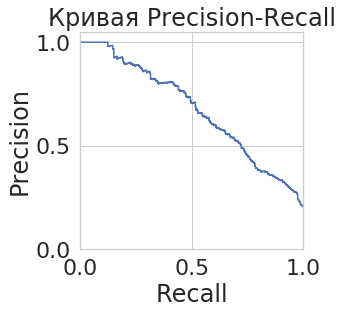

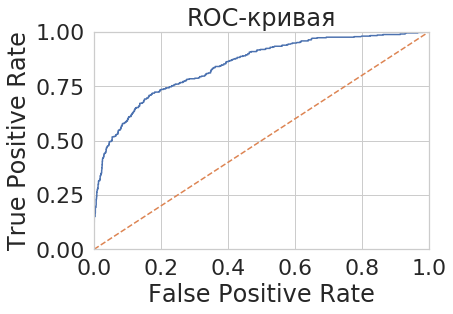

Площадь под кривой AUC-ROC равна 0.8464511589811805


In [34]:
def AdaBoostClassifier_model(X_train, y_train,X_valid, y_valid):
    # подгрузим список метрик
    metrics = np.hstack((list_metrics()))
    abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
    model = abc.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)
    current_metrics = metrics_calculate( X_train, y_train,X_valid, y_valid,y_pred,None)
    #добавим гиперпараметры в таблицу с метриками
    #current_metrics = np.hstack((np.hstack((current_metrics))))
    #добавим строчку с новыми метриками
    metrics = np.vstack((metrics,current_metrics))
    #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    #построим pr кривую
    PR_curve(y_valid,y_pred_proba)
    #построим ROC-AUC кривую
    ROC_curve(y_valid,y_pred_proba)
    return metrics
metrics_AD_boost = AdaBoostClassifier_model(feature_train_oe_sc,target_train,feature_valid_oe_sc,target_valid)       

**CatBoostClassifier**

0:	learn: 0.4159757	total: 51.7ms	remaining: 103ms
1:	learn: 0.3668890	total: 54.6ms	remaining: 27.3ms
2:	learn: 0.3418188	total: 57.8ms	remaining: 0us


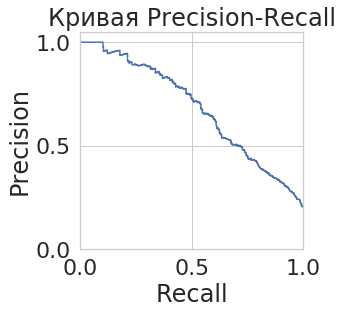

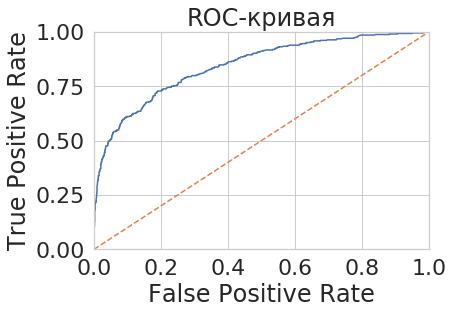

Площадь под кривой AUC-ROC равна 0.8450416912996355


In [35]:
def CatBoostClassifier_model(X_train, y_train,X_valid, y_valid):
    # подгрузим список метрик
    metrics = np.hstack((list_metrics()))
    #model = CatBoostClassifier(  bagging_temperature=1,random_strength=1,
    #thread_count=3,    iterations=500,    l2_leaf_reg = 4.0,learning_rate = 0.07521709965938336,
    #save_snapshot=True,  snapshot_file='snapshot_best.bkp',  random_seed=63,    od_type='Iter',
    #od_wait=20, custom_loss=['AUC', 'Accuracy'], use_best_model=True)
    #param = {'iterations':5}
    model = CatBoostClassifier(iterations=3, depth=7,learning_rate=1, loss_function='Logloss',verbose=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)
    #current_metrics = metrics_calculate( X_train, y_train,X_valid, y_valid,y_pred,None)
    #добавим гиперпараметры в таблицу с метриками
    #current_metrics = np.hstack((np.hstack((current_metrics))))
    #добавим строчку с новыми метриками
    #metrics = np.vstack((metrics,current_metrics))
    #создадим таблицу со значениями метрик    
    #metrics = pd.DataFrame(metrics,columns= metrics[0])
    #metrics.drop(metrics.index[0],inplace=True)
    #display(metrics.sort_values(by='_f1_score',ascending=False))
    #построим pr кривую
    PR_curve(y_valid,y_pred_proba)
    #построим ROC-AUC кривую
    ROC_curve(y_valid,y_pred_proba)
    return 1 #metrics
metrics_Catboost = CatBoostClassifier_model(feature_train_oe_sc,target_train,feature_valid_oe_sc,target_valid)    
    

Поскольку у нас нет обратной связи с заказчиком и мы не можем выяснить что важнее в нашей модели ложно-положительные предсказания ``FP`` или наоборот, что модель ложно определила клиента что он останется, а он на самом деле уйдет ``FN``. 

Поэтому мы будем использовать метрику среднего гармоническое полноты и точности, меру  **F1**. Неплохие результаты дали алгоритмы, основанные на дереьях и KNN. Логистическая регрессия на начальном этапе дала очень маленькое значение**F1**=0.32, поэтому в дальнейшем мы решили ее не рассматривать.

- DecisionTreeClassifier: Неплохой результат 0.55 без учета баланса, 0.56  с учетом. Будем пробовать бороться с дисбалансом
- RandomForestClassifier: На дефолтных параметрах дал около 0.42-0.48. Применили связку RandomizedSearchCV и GridSearchCV, получили значение 0.56. Поработав с порогом довели до 60.
- LogisticRegression : очень низкий показатель 0.34. Не стали смотреть дальше на модель.
- KNeighborsClassifier: 0.47 не плохой результат, но у деревьев лучше.
- AdaBoost and CatBoost. AdaBoost дала 0.57, попробуем этот алгоритм после борьбы с дисбалансом. Результаты бустинга схожи со случайным лесом, но требует болле подробного разбора алгоритма и настройки гиперпараметров.

# 3. Борьба с дисбалансом <a id =35></a>

Для борьбы с дисбалансов есть несколько методов, мы будем использовать upsampling  и downsampling. Т.к. мы уже исследовали модели, то делить будем только на 2 выборки - тренировочную(объединим тестовую и валидационную) и тестовую в соотношении 80:20. А так же используем кросс- валидацию. <br>Возьмем уже смасштабированные данные OrdinalEncoding, т.к. ансамбли решающих деревьев дали лучший результат на тесте

In [36]:
#Обьединим тестовую и валидационную выборки
X_train_oe = pd.concat([feature_train_oe,feature_valid_oe],axis=0).reset_index(drop=True)
X_train_ohe = pd.concat([feature_train_ohe,feature_valid_ohe],axis=0).reset_index(drop=True)
y_train = pd.concat([target_train,target_valid],axis=0).reset_index(drop=True)
X_test_oe = feature_test_oe.copy().reset_index(drop=True)
X_test_ohe = feature_test_ohe.copy().reset_index(drop=True)
y_test = target_test.copy().reset_index(drop=True)
# проверим еще раз баланс классов и стратифицированность разбиения
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(X_train_oe.shape,X_test_oe.shape,y_train.shape,y_test.shape)

False    0.8
True     0.2
Name: Exited, dtype: float64
False    0.8
True     0.2
Name: Exited, dtype: float64
(8000, 10) (2000, 10) (8000,) (2000,)


In [37]:
from sklearn.utils import shuffle
X_train_zeros = X_train_oe[y_train == 0]
X_train_ones = X_train_oe[y_train == 1]
y_train_zeros = y_train[y_train == 0]
y_train_ones = y_train[y_train == 1]
# нам нужно увеличить выборку с положительными ответами в 4 раза. Сделаем это!
repeat =4
def upsample(_zeros,_ones):
    return pd.concat([_zeros] + [_ones] * repeat)
X_train_upsampled = upsample(X_train_zeros, X_train_ones)
y_train_upsampled = upsample(y_train_zeros, y_train_ones)

print(X_train_upsampled.shape,y_train_upsampled.shape)
#перемешаем данные после балансировки
X_train_upsampled,y_train_upsample = shuffle(X_train_upsampled,y_train_upsampled, random_state=890)
# Проверим баланс классов
print(y_train_upsampled.value_counts(normalize=True))

(12890, 10) (12890,)
True     0.51
False    0.49
Name: Exited, dtype: float64


С баласом все ОК, идем дальше.

In [38]:
def downsample(zeros,ones):
    return  pd.concat([zeros.sample(frac=0.25, random_state=890)] + [ones])
X_train_downsampled = downsample(X_train_zeros, X_train_ones)
y_train_downsampled = downsample(y_train_zeros, y_train_ones)
#Проверим баланс классов и размер выборки
print(y_train_downsampled.value_counts(normalize=True))
print(X_train_downsampled.shape,y_train_downsampled.shape)

True     0.51
False    0.49
Name: Exited, dtype: float64
(3222, 10) (3222,)


Мы применили техникиUpsampling  и downsampling.Теперь балансом классов все впорядке, можем передавать данные для тестирования наших моделей.

# 4. Тестирование модели <a id =45></a>

Пришло время проверить результаты работы алгоритмов классификации на тестовой выборке.
Что будем делать:
- Посмотрим данные после upsempling
- Посмотрим данные после downsapmlin
- Оценим модель на ROC кривой

In [39]:
# пробовать на кросс валидации
# поигратся с порогами
# обьединить тестовую и валидационную

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»). Это новая метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.

**Adaboost**

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy
1,651.0,942.0,182.0,225.0,0.1928020565552699,0.5528255528255528,0.28589580686149935,0.438


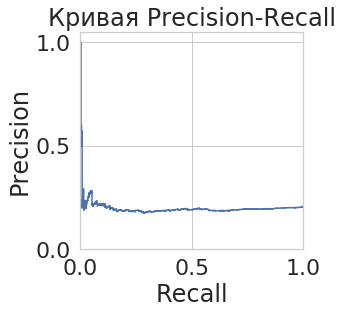

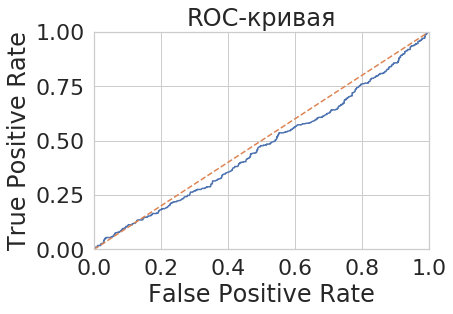

Площадь под кривой AUC-ROC равна 0.4665790597993988


In [40]:
metrics_AD_boost_up = AdaBoostClassifier_model(X_train_upsampled,y_train_upsampled,X_test_oe,y_test)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy
1,1257.0,336.0,99.0,308.0,0.4782608695652174,0.7567567567567568,0.5861084681255947,0.7825


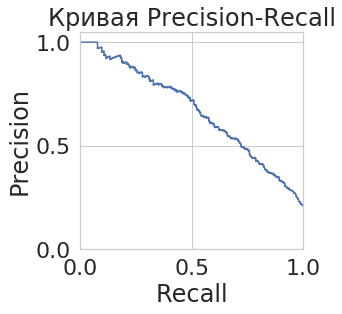

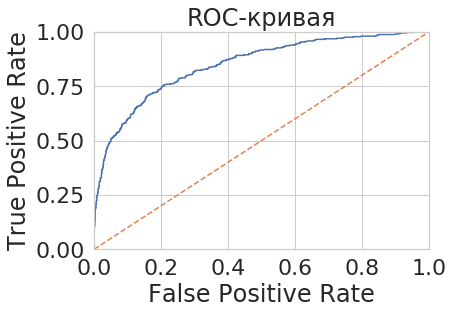

Площадь под кривой AUC-ROC равна 0.8484871620464841


In [41]:
metrics_AD_boost_down = AdaBoostClassifier_model(X_train_downsampled,y_train_downsampled,X_test_oe,y_test)    

Мы построили апроксимацию ROC кривой. В идеале площадь под этой кривой должна равняться 1, но 0.85 очень хороший результат.

**KNN model**

In [42]:
metrics_KNN = KNeighborsClassifier_model(X_train_upsampled,y_train_upsampled,X_test_oe,y_test)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,neigbors
1,814.0,779.0,189.0,218.0,0.21865596790371114,0.5356265356265356,0.31054131054131057,0.516,1.0
5,770.0,823.0,186.0,221.0,0.21168582375478928,0.542997542997543,0.3046175051688491,0.4955,5.0
17,773.0,820.0,187.0,220.0,0.21153846153846154,0.5405405405405406,0.304077401520387,0.4965,45.0
3,778.0,815.0,189.0,218.0,0.2110358180058083,0.5356265356265356,0.3027777777777778,0.498,3.0
11,811.0,782.0,195.0,212.0,0.21327967806841047,0.5208845208845209,0.3026409707351892,0.5115,15.0
9,748.0,845.0,185.0,222.0,0.20805998125585753,0.5454545454545454,0.30122116689280864,0.485,9.0
7,761.0,832.0,196.0,211.0,0.20230105465004794,0.5184275184275184,0.2910344827586207,0.486,7.0
13,766.0,827.0,198.0,209.0,0.20173745173745175,0.5135135135135135,0.2896742896742897,0.4875,25.0
16,860.0,733.0,214.0,193.0,0.2084233261339093,0.4742014742014742,0.2895723930982746,0.5265,40.0
15,765.0,828.0,198.0,209.0,0.20154291224686596,0.5135135135135135,0.2894736842105263,0.487,35.0


In [43]:
metrics_KNN = KNeighborsClassifier_model(X_train_downsampled,y_train_downsampled,X_test_oe,y_test)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,neigbors
17,856.0,737.0,162.0,245.0,0.2494908350305499,0.601965601965602,0.35277177825773937,0.5505,45.0
15,850.0,743.0,171.0,236.0,0.2410623084780388,0.5798525798525799,0.34054834054834054,0.543,35.0
16,905.0,688.0,185.0,222.0,0.24395604395604395,0.5454545454545454,0.337129840546697,0.5635,40.0
14,938.0,655.0,197.0,210.0,0.24277456647398843,0.515970515970516,0.330188679245283,0.574,30.0
9,844.0,749.0,181.0,226.0,0.2317948717948718,0.5552825552825553,0.3270622286541245,0.535,9.0
13,830.0,763.0,179.0,228.0,0.23007063572149344,0.5601965601965602,0.3261802575107296,0.529,25.0
5,833.0,760.0,180.0,227.0,0.22998986828774062,0.5577395577395577,0.32568149210903874,0.53,5.0
11,856.0,737.0,188.0,219.0,0.2290794979079498,0.538083538083538,0.32134996331621424,0.5375,15.0
3,827.0,766.0,184.0,223.0,0.22548028311425683,0.547911547911548,0.3194842406876791,0.525,3.0
7,834.0,759.0,187.0,220.0,0.2247191011235955,0.5405405405405406,0.31746031746031744,0.527,7.0


KNN модель показала результаты хуже чем до балансировки.
- Upsampling 0.29
- Downsampling 0.31

**DecisionTreeClassifier**

In [44]:
metrics_DT =DecisionTreeClassifier_model(X_train_upsampled,y_train_upsampled,X_test_oe,y_test)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,depth,class_weight
3,5.0,1588.0,0.0,407.0,0.20401002506265664,1.0,0.3388842631140716,0.206,4,None
2,5.0,1588.0,1.0,406.0,0.20361083249749248,0.9975429975429976,0.3381924198250729,0.2055,3,None
1,0.0,1593.0,0.0,407.0,0.2035,1.0,0.3381803074366431,0.2035,2,None
4,5.0,1588.0,4.0,403.0,0.2024108488196886,0.9901719901719902,0.33611342785654713,0.204,5,None
5,5.0,1588.0,4.0,403.0,0.2024108488196886,0.9901719901719902,0.33611342785654713,0.204,6,None
25,97.0,1496.0,29.0,378.0,0.2017075773745998,0.9287469287469288,0.33143358176238497,0.2375,8,balanced
6,252.0,1341.0,68.0,339.0,0.2017857142857143,0.8329238329238329,0.3248682319118352,0.2955,7,None
24,252.0,1341.0,68.0,339.0,0.2017857142857143,0.8329238329238329,0.3248682319118352,0.2955,7,balanced
8,166.0,1427.0,53.0,354.0,0.19876473891072433,0.8697788697788698,0.32358318098720296,0.26,9,None
10,504.0,1089.0,134.0,273.0,0.20044052863436124,0.6707616707616708,0.30864895421141886,0.3885,11,None


In [45]:
metrics_DT =DecisionTreeClassifier_model(X_train_downsampled,y_train_downsampled,X_test_oe,y_test)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,depth,class_weight
6,1294.0,299.0,120.0,287.0,0.48976109215017066,0.7051597051597052,0.5780463242698892,0.7905,7,None
24,1294.0,299.0,122.0,285.0,0.488013698630137,0.7002457002457002,0.5751765893037336,0.7895,7,balanced
7,1207.0,386.0,108.0,299.0,0.4364963503649635,0.7346437346437347,0.5476190476190476,0.753,8,None
25,1206.0,387.0,109.0,298.0,0.43503649635036495,0.7321867321867321,0.5457875457875457,0.752,8,balanced
22,1212.0,381.0,112.0,295.0,0.4363905325443787,0.7248157248157249,0.5447830101569714,0.7535,5,balanced
4,1212.0,381.0,112.0,295.0,0.4363905325443787,0.7248157248157249,0.5447830101569714,0.7535,5,None
5,1202.0,391.0,109.0,298.0,0.432510885341074,0.7321867321867321,0.5437956204379563,0.75,6,None
23,1202.0,391.0,109.0,298.0,0.432510885341074,0.7321867321867321,0.5437956204379563,0.75,6,balanced
8,1211.0,382.0,116.0,291.0,0.4323922734026746,0.714987714987715,0.538888888888889,0.751,9,None
26,1194.0,399.0,115.0,292.0,0.42257597684515197,0.7174447174447175,0.5318761384335156,0.743,9,balanced


KNN модель показала результаты лучше чем до балансировки.
- Upsampling 0.41
- Downsampling 0.60
Отметим что глубина дерева при которых модель выдает хороший результат.

**RandomForestClassifie**

Результат после подбора параметрами RandomizedSearchCV и GridSearchCV для f1_score 0.3025974025974026


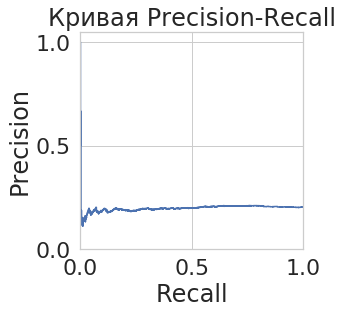

True     1133
False     867
dtype: int64

True     1133
False     867
dtype: int64

False    1593
True      407
Name: Exited, dtype: int64

,7,4,5,6,8,0,1,2,3,9,10,11,12,13,14,15,16,17,18,19
f1_score,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.33,0.33,0.33,0.3,0.26,0.20,0.13,0.07
threshold,0.34,0.28,0.30,0.32,0.36,0.20,0.22,0.24,0.26,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58


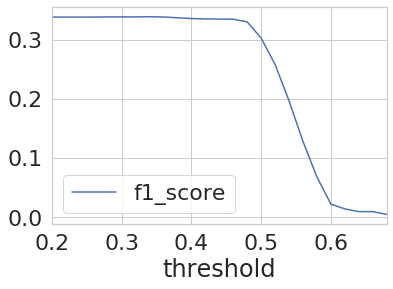

In [46]:
#upsample
predicted_value_RF_up, pedicted_value_proba_RF_up = RandomForestClassifier_model(best_params,X_train_upsampled,y_train_upsampled,X_test_oe,y_test)
threshold_selection(predicted_value_RF_up, pedicted_value_proba_RF_up,y_test)

Результат после подбора параметрами RandomizedSearchCV и GridSearchCV для f1_score 0.5855940130963517


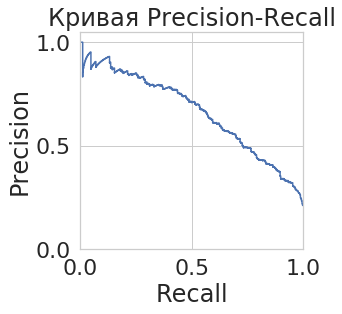

False    1338
True      662
dtype: int64

False    1338
True      662
dtype: int64

False    1593
True      407
Name: Exited, dtype: int64

,19,20,18,21,24,22,23,17,16,15,14,13,12,11,10,9,8,7,6,5
f1_score,0.62,0.61,0.61,0.61,0.61,0.61,0.61,0.60,0.59,0.59,0.58,0.57,0.56,0.55,0.55,0.53,0.52,0.50,0.49,0.48
threshold,0.58,0.60,0.56,0.62,0.68,0.64,0.66,0.54,0.52,0.50,0.48,0.46,0.44,0.42,0.40,0.38,0.36,0.34,0.32,0.30


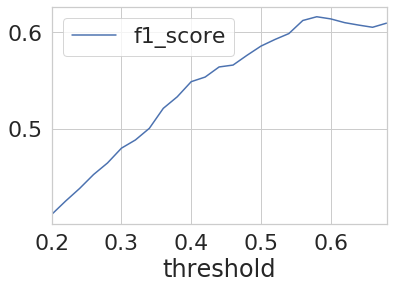

In [47]:
#dwonsample
predicted_value_RF_up, pedicted_value_proba_RF_up = RandomForestClassifier_model(best_params,X_train_downsampled,y_train_downsampled,X_test_oe,y_test)
threshold_selection(predicted_value_RF_up,pedicted_value_proba_RF_up,y_test)

RandomForestClassifier модель показала результаты лучше чем до балансировки.
- Upsampling 0.57
- Downsampling 0.62


**Вывод**: модели после балансировки показывают более лучшие результаты метрики F1. Как можно было заметить  значения Precission and Recall примерно одинаковые поэтому метрика F1 и показывает неплохой результат при том же Accuracy. В принципе на сбалансированных классах можно ориентироваться на Accuracy т.к. она дает схожий результат.
Лучшего результата мы добились на downsampling используя алгоритм - Случайных лес и изменение порога. Мера F1 составила 0.62.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*